## Analyzing tweets

This notebook analyzes tweets about the pixel 2 collected around the time of the product announcement with the goal of getting the general sentiment toward the announcement and product itself, and also use topic modeling to check what aspects of the announcement are being discussed in particular. Twitter's streaming api was used and returns data in a JSON format which was then saved to a file. The textblob library is used here to measure sentiment of the tweets, textblob assigns values between -1 to 1 to words and phrases. This is an unsupervised way of measuring the general sentiment, and  as a result the tweets don't need to be labeled manually first and trained on. 

In [24]:
# parsing
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import re
import string
import spacy

# sentiment scoring
from textblob import TextBlob
from itertools import islice

# basic visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# LDA
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
#from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings('ignore')


In [4]:
nlp = spacy.load('en')

In [5]:
t_list = []        
with open("tweets.txt", "r") as f:
    t_list =[]
    for line in f:
        tweet = json.loads(line)
        t_list.append(tweet)        

In [6]:
texts = [item['text'] for item in t_list]

In [23]:
print('Here is an example of a tweet: \n{}'.format(texts[8]))
print('There are {} tweets in the dataset.'.format(len(texts)))

Here is an example of a tweet: 
And if you aren't a new user to YouTube Red, then you won't get a discount on anything because you're a sucker. #GoogleEvent #Pixel2
There are 3465 tweets in the dataset.


To get decent results a certain amount of text cleaning must be done to retreive words that are consistently conjugated. My text cleaning function incorporates removal of numbers and punctuation, and the spacy library provides a fast way of using stem words to replace conjugated words. Other parts of text cleaning data can be a subjective process, especially choosing what words to remove. In this case it made sense to remove words like "google" since they would be expected to show up frequently and don't add much meaning to the analysis. 

In [25]:
def join_not(text):
    replace_these = re.findall(r'not\s+\w+', text)
    for item in replace_these:
        tmp = item.replace(' ', '_')
        text = text.replace(item, tmp)
    return text

In [2]:
# consider splitting this function to clean text, do phrase modeling, and then remove stop words instead of removing stop words first

def clean_text(text, join = False):
    
    # remove HTML
    text = BeautifulSoup(text, "html.parser").get_text()
    
    #removes url
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
       
    # removes numbers, symbols, nextline symbols 
    text = re.sub("[^a-zA-Z' ]"," ", text)   
    text = text.replace(r"\n", '').replace('  ', ' ').lower().strip('.')
    
    # removes some possessive, needs improvement
    text = re.sub(r"'s", "", text)
    if join_not:
        text = join_not(text)
    text = nlp(text)
    
    # removes punctuation and pronouns, random words
    words=[]
    for word in text:
        if word.pos_ != 'PUNCT' and word.pos_ != 'PRON' and not word.is_space: 
            words.append(word.lemma_)
                
    unigrams = [word for word in words if word not in ["t", "s", "v", "'s", "pixel", "rd", "madebygoogle", "google", "xl", "pixelxl", 
                                                       "phone", "android", "new", "googleevent", "googlepixel"
                                                      ]
               ]
    
    return unigrams

In [70]:
def remove_stops(unigrams, removal=''):
    
    # removes punctuation and pronouns, returns lemmatized word
    lex = nlp.vocab['not'] # adds not to vocab not stopwords
    lex.is_stop = False
    
    if removal:
        try:
            spacy.en.STOP_WORDS.remove(removal)
            pass
        except:
            pass
    
    unigrams = [word for word in unigrams if word not in spacy.en.STOP_WORDS]
    return unigrams

 Regex notes
 
() -- this is the group you want to capture and output  
\s -- match space character  
\w+ -- match word of any length(+), character can also be [a-zA-z]+

"Not" is frequently counted as a word to be removed, I have decided to leave it in because it also frequently signifies a negative sentiment in combination with a positive adjective, such as "not good". Which are accounted for by the textblob library. A few tweets with the key word are listed below, note the "not interested" and "not needed" phrases.

In [71]:
tdf = pd.DataFrame(t_list)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)

for i,item in islice(enumerate(tdf['text'].str.findall(r'.*not\s.*')), 500):
    if item != []:
        print(i, item)

6 ["Sorry Apple, it's not you. It's me. Well, it's kinda you. But also, I found someone else...  #Google #pixel2… https://t.co/6JU0Nfrbgx"]
16 ['Google smart speaker Thats not a speaker thats DJ 🙂🙂 https://t.co/8OWbVLDtG1']
38 ['Google in 2016: “3.5mm headphone jack satisfyingly not new”']
54 ['Dear @Google please show me the #pixel2 @madebygoogle - i am not interested in Pixel book. https://t.co/O480z61jly']
132 ['Oh dear. The #Pixel2 looks... not good.']
156 ['Not that u have not seen the #Pixel2 but at least this is an official pic! https://t.co/uWy3Xa9I0S']
163 ['So @google not going to call it Pixel II ? #Pixel2']
223 ['The #Pixel2 does not have a headphone jack 🤔']
282 ["Clearly I'm not going to buy this shit."]
336 ['Let’s see how many people say they refuse to buy the #Pixel2 because of no headphone jack and how it’s not worth it without one.']
392 ['So was I the only one who took that Apple bite during the #pixel2 opener as “Yeah, we’re not including a headphone jack, too”?']


In [72]:
f = lambda x: remove_stops(clean_text(x, True))
tweet_list = [f(item) for item in texts]

## Phrase modeling 

Phrase modeling looks at the cleaned texts and compares them to see which words are frequently occuring next to each other, if they surpass a certain threshold the algorithm joins them like the word headphone_jack below.

In [73]:
bigrams = models.phrases.Phraser(models.Phrases(tweet_list))
bigram_phrases = [bigrams[tweet] for tweet in tweet_list]
trigrams = models.phrases.Phraser(models.Phrases(bigram_phrases))
trigram_phrases = [trigrams[tweet] for tweet in bigram_phrases]

In [74]:
from collections import Counter

Counter([word for line in trigram_phrases for word in line]).most_common(20)

[('camera', 231),
 ('apple', 226),
 ('headphone_jack', 200),
 ('good', 174),
 ('look', 148),
 ('iphone', 131),
 ('launch', 115),
 ('want', 96),
 ('come', 92),
 ('buy', 91),
 ('year', 89),
 ('like', 87),
 ('event', 85),
 ('pixelbook', 81),
 ('iphonex', 81),
 ('feature', 79),
 ('squeeze', 78),
 ('smartphone', 72),
 ('announce', 71),
 ('use', 71)]

In [75]:
from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
})
sns.set_style("whitegrid")

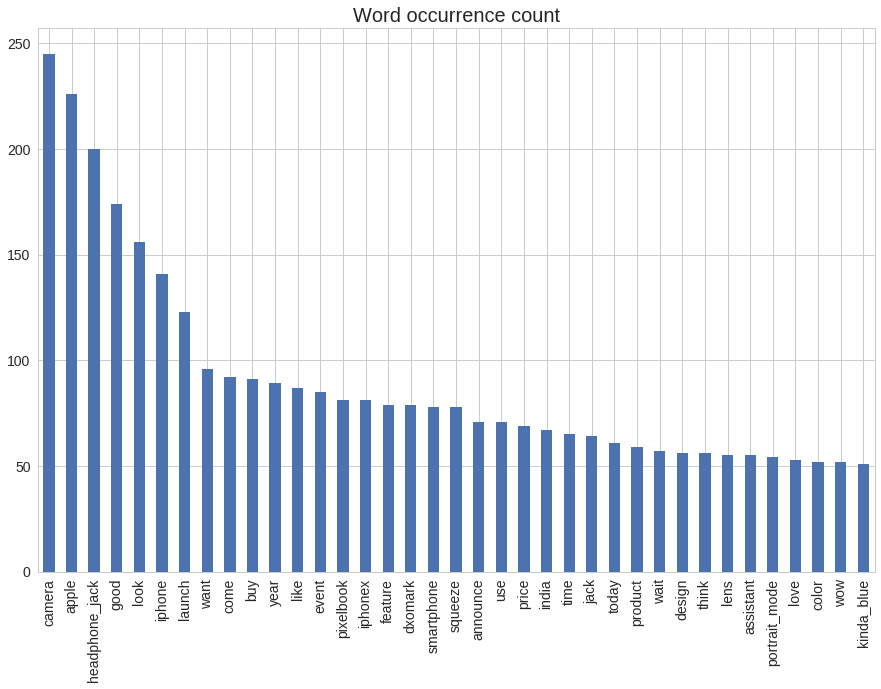

In [76]:
tweet_words = [word for tweet in bigram_phrases for word in tweet]
tweet_words = pd.Series(tweet_words)
tweet_words.value_counts()[tweet_words.value_counts() > 50].plot(kind = 'bar', figsize = (15, 10))
plt.title("Word occurrence count")
plt.show()


The most frequently mentioned words above gives us a rough idea of what people are thinking of regarding the announcement. Not suprisingly, the camera, headphone_jack, and it's main competitor apple are mentioned the most frequently. 

## Sentiment analysis

Sentiment provides a better idea of how people reacted to the announcement and potentinally insight into what aspects of the product people liked and disliked. The polarity score is the numerical value assigned to the feel of a tweet, and is the score being displayed below. 

In [82]:
def sentiment(question):
    
    pol_sub = [TextBlob(question).sentiment.polarity, 
               TextBlob(question).sentiment.subjectivity]
    return pol_sub           

def unsplit(words):
    
    sent = str('')
    for word in words:
        if len(sent)==0:
            sent = word
        else:    
            sent = sent + ' ' + word
    return sent    

In [83]:
f = lambda x: sentiment(unsplit(x))

tweet_sentiment = [f(item) for item in bigram_phrases]

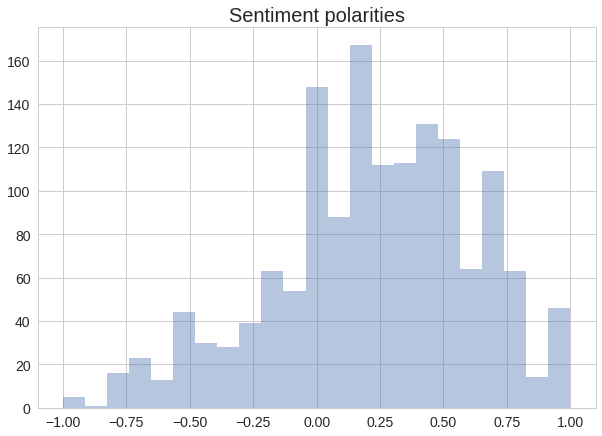

In [84]:
# neutral tweets are removed
polarities = [pol[0] for pol in tweet_sentiment if pol[1] != 0]
plt.figure(figsize = (10,7))
sns.distplot(polarities, kde = False)
plt.title("Sentiment polarities")
plt.show()

In [85]:
print("mean: {:0.4f}".format(np.mean(polarities)))
print("median: {:0.4f}".format(np.median(polarities)))
print("99th percentile: {:0.4f}".format(np.percentile(polarities, 99)))
print('{} {:0.4f}'.format("std:", np.std(polarities)))

mean: 0.2239
median: 0.2500
99th percentile: 1.0000
std: 0.3976


The distribution of sentiment skews left, and looks somewhat positive. The mean and median are around .2 but the standard deviation is almost .4. Not sure if these sentiments are just random yet. It might be interesting to look at some of the positive and negative tweets directly.

In [86]:
pol = [item[0] for item in tweet_sentiment]

In [87]:
tdf = pd.concat([tdf, pd.DataFrame({'pol': pol})], axis = 1)

In [92]:
tdf.text[tdf.pol > .75][0:10]

30     Beautiful. Pixelbook really is beautiful. #Pix...
85     Let me guess the #Pixel2 uses AI and machine l...
124    No shock in the #pixel2 design. Leaked weeks a...
201    And there they are - beautiful! #Pixel2 #madeb...
205                Lol no headphone jacks on the #Pixel2
210    Front Facing Speakeeers, omg I'm so happy #Pixel2
301                    Welcome to the NoAux Club #pixel2
349    Front facing stereo speakers on #Pixel2 is jus...
492                                  #Pixel2 for the win
555    I guess @StarFire2258 won’t be buying one. \n\...
Name: text, dtype: object

Followed by some very negative tweets:

In [91]:
tdf.text[tdf.pol < -.75][0:10]

143     #madebygoogle give us the bloody headphone jac...
267     Holy crap @Google killed the headphone jack on...
445     this is so retarded. there's no "courage" in g...
611     Squeeze your phone for Google Assistant is ins...
955     The iOS11 screenshot change is annoying enough...
987     The #Pixel2 has a DXO score of 98. Ninety-eigh...
1128    #dxomark #Mobile #Pixel2 Top ranked for mobile...
1141    This is insane! #madebygoogle #Pixel2 #pixel2x...
2148    That #googleevent was insane. This is very bad...
2208    #Pixel2 has no headphone jack. Will there be a...
Name: text, dtype: object

Sounds like people were happy about the camera, but disliked the lack of a headphone jack.

## Hypothesis testing

Hypothesis testing can be used to give more statistical support that the tweet data does indeed represent a positive reaction to the announcement.

In [93]:
# draw samples and calculate test statistic for boostrap testing, with replacement by default

def draw_sample(array, size = 1000):
    idx = np.random.choice(len(array), size)
    return [array[i] for i in idx]

def calc_stat(array, num_samples, size, func):
    sample_list = []
    for num in np.arange(num_samples):
        sample_list.append(func(draw_sample(array, size)))
    return sample_list


1.0


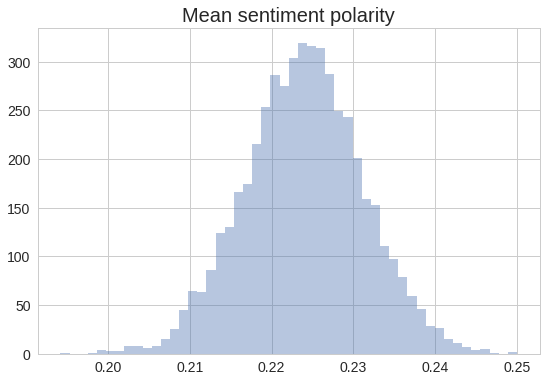

In [94]:
# test for how significant is in sentiment value

#draw_sample(polarities)
pol_means = calc_stat(polarities, 5000, 3000, np.mean)
sns.distplot(pol_means, kde = False)

# prob the mean sentiment is greater than 0
print(np.sum(np.array(pol_means) > 0)/len(pol_means))
plt.title("Mean sentiment polarity")    
plt.show()

From the histogram above, all the bootstrapped sample means are greater than 0. Therefore, it's very unlikely that the total sentiment towards the announcement is neutral. Indicating that sentiment towards the pixel 2 announcement was significantly positive. A larger tweet size should be considered before concluding that to be the case nationally, by running the twitter streamfilter for longer.

In [69]:
print('Another way to get a sense of the tweet sentiment, roughly {} times the number of positive to negative tweets the'.format(np.sum(pd.Series(polarities) > 0) / np.sum(pd.Series(polarities) < 0)) + 
      '\n' + 'weekend after the movie.')

Another way to get a sense of the tweet sentiment, roughly 3.2184615384615385 times the number of positive to negative tweets the
weekend after the movie.


# POS tagging with spacy

In [95]:
def get_pos(text):
    a = []
    for word in nlp(text):
        if word.pos_ == "ADJ":
            a.append(word.lower_)
    return a        

In [96]:
bigram_sents = [' '.join(line) for line in tweet_list]
adj_list = [get_pos(sent) for sent in bigram_sents]

In [97]:
adj_words = [word for sent in adj_list for word in sent]
adj_words = [word for word in adj_words if not word in STOPWORDS]

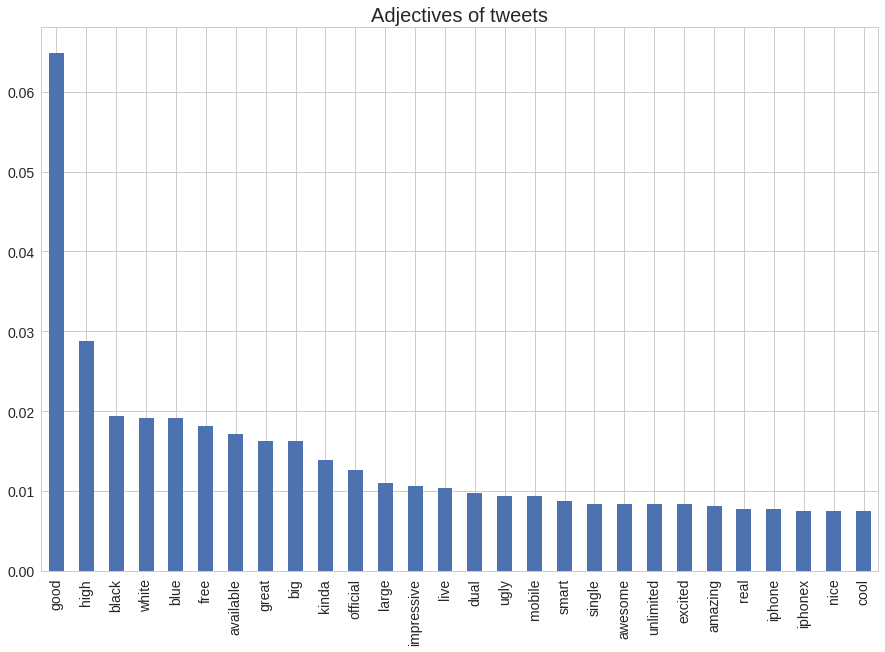

In [98]:
adj_words = pd.Series(adj_words)
adj_words.value_counts(normalize=True)[adj_words.value_counts() > 20].plot(kind = 'bar', figsize = (15, 10))
plt.title("Adjectives of tweets")

plt.show()

## Wordcloud of tweet adjectives

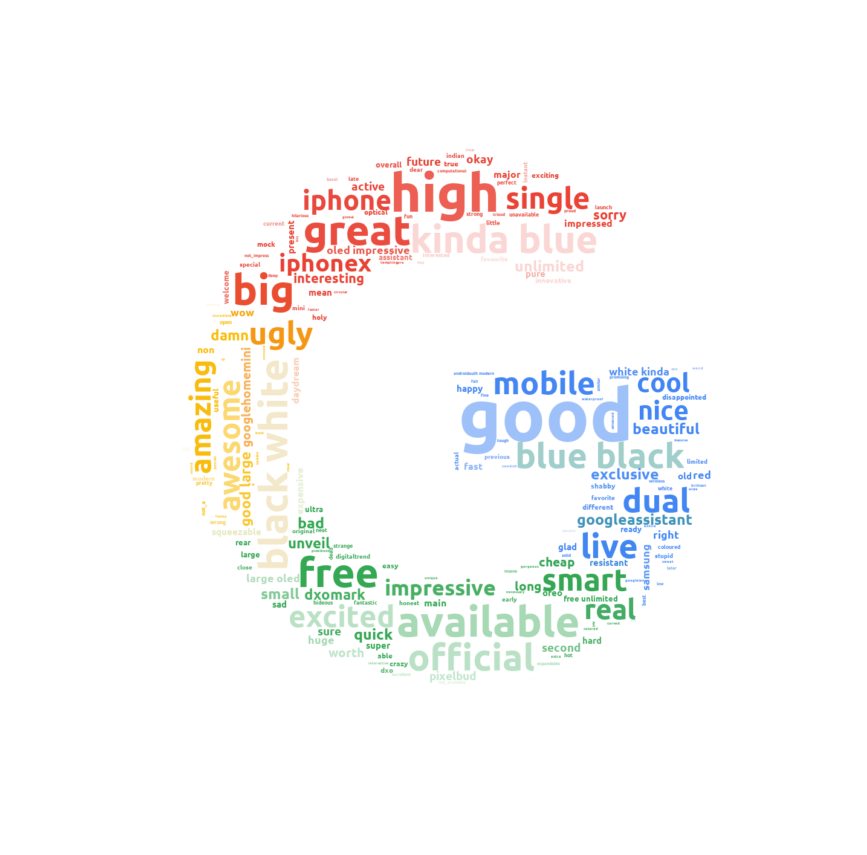

In [99]:
from scipy.misc import imread
from PIL import Image

font = '/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf'
ww_img = imread("./images/google.jpg")
coloring = np.array(Image.open("./images/google.jpg"))
image_colors = ImageColorGenerator(coloring)
    
wc = WordCloud(font_path = font, mask= ww_img, max_font_size=80, min_font_size=2, 
                width=1000, height=1000, background_color = "white", 
                stopwords = STOPWORDS, max_words=200, scale = 1.5)

wc.generate(' '.join(adj_words))
plt.figure(figsize = (20, 15))
plt.imshow(wc.recolor(color_func = image_colors), interpolation="bilinear")
plt.axis("off")
plt.show()

## Word vectors

The contextual similarity of words can be somewhat visualized by a TSNE transformation of the vectors and getting a graphical representation of the word vectors in 2 dimensions.

In [100]:
w2vec = models.Word2Vec(bigram_phrases)

In [101]:
vocab = list(w2vec.wv.vocab)
X = w2vec[w2vec.wv.vocab]

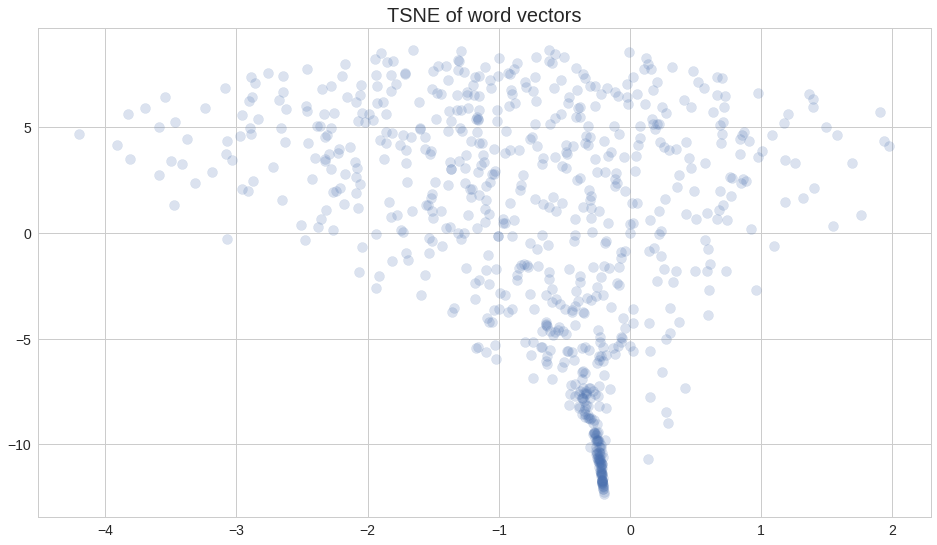

In [102]:
model = TSNE(learning_rate=200, perplexity=100, n_iter=1000)
tsne_features = model.fit_transform(X)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
plt.figure(figsize = (16,9))

# Scatter plot
plt.scatter(xs, ys, alpha=0.2)

# Annotate the points
#for x, y, word in zip(xs, ys, vocab):
#    plt.annotate(word, (x, y), fontsize=11, alpha=0.9)
plt.title('TSNE of word vectors')
plt.show()

It looks like the word vectors are not similar based on the diagram, although tweets are only 140 characters so it's hard to judge by the tsne graph. LDA topic analysis might be able to tell us more.

## Topic modeling 

In [104]:
tweet_dict = Dictionary(bigram_phrases)
corpus_tweet = [tweet_dict.doc2bow(phrase) for phrase in bigram_phrases]
tfidf_model = models.TfidfModel(corpus_tweet)
tfidf_corpus = tfidf_model[corpus_tweet]

In [122]:
lda2 = LdaModel(corpus=corpus_tweet, id2word=tweet_dict, num_topics=10, update_every=1, chunksize=10000, passes=4, random_state = 5)

In [123]:
lda2.show_topics(num_topics=-1, num_words=4)

[(0,
  '0.020*"pixelbook" + 0.015*"digitaltrend" + 0.014*"come" + 0.010*"finally_set"'),
 (1, '0.014*"time" + 0.012*"buy" + 0.010*"use" + 0.009*"headphone_jack"'),
 (2, '0.024*"want" + 0.019*"look" + 0.012*"headphone_jack" + 0.011*"launch"'),
 (3, '0.022*"dxomark" + 0.021*"good" + 0.018*"kinda_blue" + 0.016*"apple"'),
 (4, '0.044*"apple" + 0.028*"year" + 0.019*"headphone_jack" + 0.017*"iphone"'),
 (5,
  '0.034*"camera" + 0.030*"look" + 0.025*"squeeze" + 0.024*"portrait_mode"'),
 (6, '0.012*"today" + 0.012*"launch" + 0.011*"ugly" + 0.011*"gb"'),
 (7, '0.026*"camera" + 0.018*"good" + 0.017*"tech" + 0.016*"announce"'),
 (8,
  '0.027*"headphone_jack" + 0.021*"india" + 0.019*"launch" + 0.016*"camera"'),
 (9,
  '0.017*"camera" + 0.017*"headphone_jack" + 0.017*"wait" + 0.017*"win_caseology"')]

In [124]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda2, corpus_tweet,
                                              tweet_dict)

In [125]:
pyLDAvis.display(LDAvis_prepared)

LDA uses unsupervised learning to distribute the tweet data into ten topics. Each topic consists of sets of words that describe them, the chart to the left represents the topics in 2-dimensional space like TSNE. Unlike TSNE they also maintain the distance between each topic cluster, and it looks like topic 10 stands out from the rest. Highlighting topic 10 gives the most frequently occuring words within the topic such as kinda_blue, white, and black_clearly. Indicating that topic 10 seems to be about color, similarly the other topics relatively close to each other and seem to reflect discussion about the camera and headphone jack. 